<a href="https://colab.research.google.com/github/Fedeloz/TFG/blob/main/TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network

#### import libraries, set up information and read Data



In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import return_pixel_df
import logging as log
from IPython.display import display

num_img = 8000     # number of images generated per type
size    = 64       # img will be size x size
max     = 40000000

assert size**2*num_img <= max, 'size is over the maximum, (' + str(size**2*num_img) + ' > 40000000)' # check that we are inside the bounds
parity_matrix_path = 'parity1024m.mat'   # L -> Pseudo random, shape = 1x40000000
random_matrix_path = 'urand1024_2.mat'   # R -> True random,   shape = 1x200000000
data               = 'Data'

df_pixel = return_pixel_df.returnDF(parity_matrix_path, random_matrix_path, num_img, size, data)
display  (df_pixel)


,Label,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,Pixel 10,Pixel 11,Pixel 12,Pixel 13,Pixel 14,Pixel 15,Pixel 16,Pixel 17,Pixel 18,Pixel 19,Pixel 20,Pixel 21,Pixel 22,Pixel 23,Pixel 24,Pixel 25,Pixel 26,Pixel 27,Pixel 28,Pixel 29,Pixel 30,Pixel 31,Pixel 32,Pixel 33,Pixel 34,Pixel 35,Pixel 36,Pixel 37,Pixel 38,...,Pixel 4056,Pixel 4057,Pixel 4058,Pixel 4059,Pixel 4060,Pixel 4061,Pixel 4062,Pixel 4063,Pixel 4064,Pixel 4065,Pixel 4066,Pixel 4067,Pixel 4068,Pixel 4069,Pixel 4070,Pixel 4071,Pixel 4072,Pixel 4073,Pixel 4074,Pixel 4075,Pixel 4076,Pixel 4077,Pixel 4078,Pixel 4079,Pixel 4080,Pixel 4081,Pixel 4082,Pixel 4083,Pixel 4084,Pixel 4085,Pixel 4086,Pixel 4087,Pixel 4088,Pixel 4089,Pixel 4090,Pixel 4091,Pixel 4092,Pixel 4093,Pixel 4094,Pixel 4095
0,0,1,1,0,1,0,1,1,0,0,1,1,1,0,0,0,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,1,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,1,1,1,0,0,1,0,1,0,1,1,0,0,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0
1,0,1,1,1,0,1,0,1,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,0,1,1,0,0,1,...,1,1,1,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0
2,0,1,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,...,0,1,0,1,1,0,0,1,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1
3,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1,1,0,0,1,1,...,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,1,0,1,0,1
4,0,1,0,0,0,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,1,1,1,0,0,1,0,0,1,0,1,1,0,1,0,1,1,0,0,...,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,1,0,1,0,1,1,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0
15996,1,0,0,0,0,1,0,0,1,1,1,1,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1,0,1,0,1,1,0,0,1,...,1,0,0,1,1,0,1,1,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1
15997,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,1,...,0,0,1,0,1,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,0,1,1,0
15998,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,1,1,0,0,1,1,1,0,1,0,0,1,1,1,1,1,...,0,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,1,1,0,0,1,1,0,1,1,0,1,0,0


## Plot Data

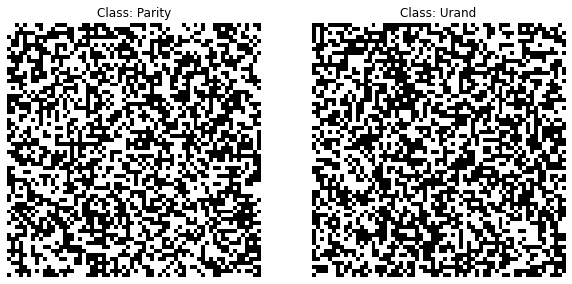

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
label = ['Parity', 'Urand']
for i in range (len(label)):
    plt.subplot(1, 2, i+1)
    img = df_pixel[df_pixel['Label']==i].iloc[0,1:].values
    img = img.reshape((size, size))
    plt.imshow(img, cmap='gray')
    plt.title("Class: " + label[i])
    plt.axis('off')
    
plt.show()

## Reshape

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical     # Label Encoding

X = df_pixel.drop(["Label"], axis=1)
y = df_pixel['Label']
y = to_categorical(y, num_classes=2)                # Se pasa a categoriacal, para que así no tenga más valor la etiqueta 1 que la 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = X_train.values.reshape(-1, size, size, 1)
X_test  = X_test.values.reshape (-1, size, size, 1)

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

X_train shape (11200, 64, 64, 1)
X_test shape (4800, 64, 64, 1)
y_train shape (11200, 2)
y_test shape (4800, 2)


## Implementación de la red neuronal convolucional



In [ ]:
from keras.optimizers import RMSprop, Adam

optimizer = Adam(learning_rate=0.001, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=None, 
                 decay=0.0, 
                 amsgrad=False)

In [ ]:
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#-------------------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------------------#

model = Sequential()    # Linear Layering

model.add(Conv2D(32, (3, 3), input_shape = (size, size, 1), activation = 'relu'))           # 32 filtros convolucionales 3x3
# model.add(Conv2D(64, (3, 3), input_shape = (size, size, 1), activation = 'relu'))           # 64 filtros convolucionales 3x3
model.add(MaxPooling2D(pool_size = (2, 2)))                                                 # down-sampling by half. Agrupacion
# model.add(Dropout(0.25))                                                                  # Elimina diferentes variables para evitar overfitting

model.add(Flatten())                                                                        # flatten, projecting to lower dimensions

model.add(Dense(units = 128, activation = 'relu'))                                          # input layer with 128 inputs to prevent overfitting
model.add(Dense(units = 2, activation = 'sigmoid'))                                         # activation layer. softmax para recibir probabilidades

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])  # compiling
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 3,936,962
Trainable params: 3,936,962
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
epochs = 50
batchSize = 100 # Tamaño de lote

cnn  = model.fit(x= X_train, y= y_train, validation_data=(X_test, y_test), steps_per_epoch = 50, 
                                                        epochs = epochs, validation_steps=10, 
                                                        batch_size=batchSize)

Epoch 1/50
50/50 [==============================] - 13s 250ms/step - loss: 1.3371 - accuracy: 0.4967 - val_loss: 0.7001 - val_accuracy: 0.4990
Epoch 2/50
50/50 [==============================] - 12s 237ms/step - loss: 0.7005 - accuracy: 0.4970 - val_loss: 0.7274 - val_accuracy: 0.5010
Epoch 3/50
50/50 [==============================] - 11s 228ms/step - loss: 0.6978 - accuracy: 0.5454 - val_loss: 0.6951 - val_accuracy: 0.4920
Epoch 4/50
50/50 [==============================] - 11s 227ms/step - loss: 0.6745 - accuracy: 0.6225 - val_loss: 0.7062 - val_accuracy: 0.5010
Epoch 5/50
50/50 [==============================] - 11s 229ms/step - loss: 0.6772 - accuracy: 0.5671 - val_loss: 0.6996 - val_accuracy: 0.5000
Epoch 6/50
50/50 [==============================] - 12s 230ms/step - loss: 0.6264 - accuracy: 0.7175 - val_loss: 0.7010 - val_accuracy: 0.5160
Epoch 7/50
50/50 [==============================] - 12s 239ms/step - loss: 0.6249 - accuracy: 0.6717 - val_loss: 0.7102 - val_accuracy: 0.5250

# Evaluación del modelo

In [ ]:
print("Accuracy after fitting: {:.2f}%".format(cnn.history['accuracy'][-1]*100))


Accuracy after fitting: 100.00%


#### Para una mayor precisión, puede aumentar el número de épocas o puede cambiar los parámetros en las capas o puede agregar una capa adicional al modelo.

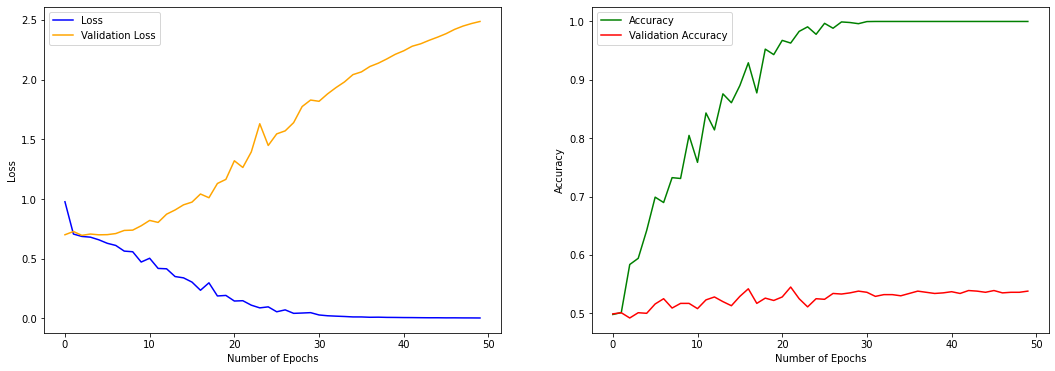

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(cnn.history['loss'], color="blue", label = "Loss")
plt.plot(cnn.history['val_loss'], color="orange", label = "Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn.history['accuracy'], color="green", label = "Accuracy")
plt.plot(cnn.history['val_accuracy'], color="red", label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test)
print("Test Loss: {:.4f}".format(score[0]))
print("Test Accuracy: {:.2f}%".format(score[1]*100))

150/150 [==============================] - 4s 23ms/step - loss: 2.6518 - accuracy: 0.5150
Test Loss: 2.6518
Test Accuracy: 51.50%


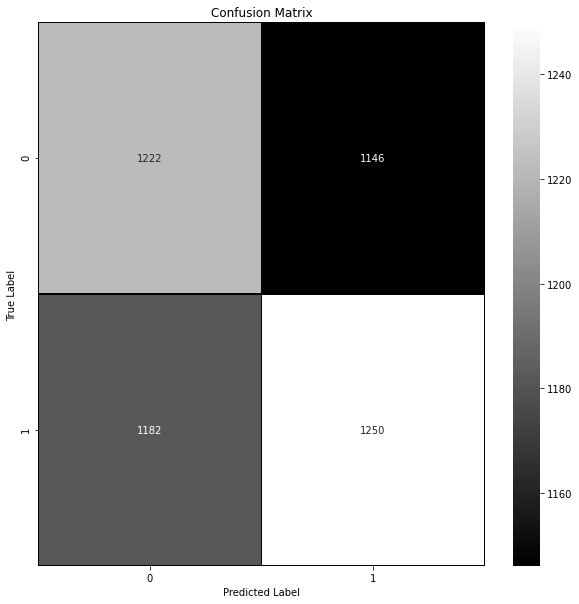

In [ ]:
import seaborn as sns
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(y_test, axis = 1)
confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)

f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()